In [2]:
import os
import pandas as pd
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader,Subset
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score


In [7]:
csv_path = 'e:/mlprojectdata/samples/'

train_csv = pd.read_csv(csv_path + 'random_trainset.csv')
val_csv = pd.read_csv(csv_path + 'random_testset.csv')
train_csv.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,37cc5444-bba9-11e8-b2ba-ac1f6b6435d0,25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2a947e68-bbaa-11e8-b2ba-ac1f6b6435d0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8a750574-bbbd-11e8-b2ba-ac1f6b6435d0,6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1a8b4196-bba0-11e8-b2b9-ac1f6b6435d0,16 14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42f31a2e-bbbd-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
label_counts = train_csv.drop(["Id", "Target"],axis=1).sum(axis=0)/len(train_csv)
label_counts[:3]

Nucleoplasm         0.409639
Nuclear membrane    0.044949
Nucleoli            0.116775
dtype: float64

In [63]:
class ImgDataset(Dataset):

    def __init__(self,frames, root_dir, transform=None, labels = 28):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frames = frames
        self.root_dir = root_dir
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.frames.iloc[idx, 0]+'.png')
        #image = open_rgby(img_name)
        #image = load_image(self.frames.iloc[idx, 0],self.root_dir)
        img = Image.open(img_name)
        label=  torch.tensor(self.frames.iloc[idx, 2:(2+self.labels)].tolist(), dtype=torch.float32)

        if self.transform:
            #temp_img = Image.open(sample['image'])
            img = self.transform(img)
            img /= 255 
            
        sample = {'image': img, 'label': label}
        return sample

In [64]:
transformer = transforms.Compose([#transforms.Resize(128),
                                 transforms.ToTensor()])

data_path = 'e:/mlprojectdata/'

train_dataset = ImgDataset(frames=train_csv,
                           root_dir=data_path+'updated_train/', transform=transformer, labels = 3)
val_dataset = ImgDataset(frames=val_csv,
                           root_dir=data_path+'updated_train/', transform=transformer, labels = 3)

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,num_workers=0)


In [21]:
import time
import seaborn as sns

In [65]:
# Testing
start_time = time.time()

for i, data in enumerate(train_loader):
    x, target = data['image'], data['label'].int()
    if i==0:
        print(x.size(0))
    if i % 10 == 0:
        print('loading batch '+ str(i) + '....')
        print(target.shape)
print(len(train_loader.dataset))

end_time = time.time()
print('time cost:'+str(end_time-start_time))

32
loading batch 0....
torch.Size([32, 3])
loading batch 10....
torch.Size([32, 3])
loading batch 20....
torch.Size([32, 3])
loading batch 30....
torch.Size([32, 3])
loading batch 40....
torch.Size([32, 3])
loading batch 50....
torch.Size([32, 3])
loading batch 60....
torch.Size([32, 3])
2158
time cost:30.898091554641724


In [107]:
# Create CNN Model
class MultiClassifier(nn.Module):

    def __init__(self,nclasses=28):
        #self.nclasses=3 # This needs to be changed when using different number of classes for developing model
        super(MultiClassifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(nn.Conv2d(in_channels=4, out_channels=32, kernel_size=12, stride=5, padding=0), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=3,stride=2)
                                       )
        self.ConvLayer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2,stride=2)
                                       )
        self.ConvLayer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=0), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=3,stride=2),
                                        nn.Dropout(0.25)                                          
                                       )
        self.Linear1 = nn.Linear(96 * 10 * 10, 1024)
        self.Linear2 = nn.Linear(1024, 256)
        self.Linear3 = nn.Linear(256, nclasses) 
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        x = self.Linear3(x)
        return torch.sigmoid(x)

In [179]:
def fit_model(epochs, model, data_loader, sigmoid = False, phase = 'training'):
    
    print("Epoch: {}".format(epochs))
    if phase == 'training':
        model.train()
        
    if phase == 'validataion':
        model.eval()
        
    probablity = []    
    running_loss =0
    running_f1 =0
    running_acc=0
    running_macrof1 =0
    cnt=0
    for i, data in enumerate(data_loader):
        
        x, target = data['image'], data['label'].float()
        #print(len(x.shape), len(target))
        #x, target = Variable(x), Variable(target)
        
        if phase == 'training':
            optimizer.zero_grad()
            
        out = model(x)
        loss = criterion(out, target)         
        preds = []
        if sigmoid:
            out_p = torch.sigmoid(out.data)
            preds= out_p > prob_threshold
            if i == 0:
                print('sigmoid actived.....')
                print(out_p)
        else:
            out_p = out.data
            preds= out_p > prob_threshold
            if i == 0:
                print('sigmoid not used.....')
                print(out.data)
            
        preds=preds.to(torch.float32)
        
        if phase == 'training':            
            loss.backward()        
            optimizer.step()
        else:
            out_p = out_p.detach().numpy()      
            for n in range(out_p.shape[0]):
                probablity.append(out_p[n])

        running_loss+=loss.item()*x.size(0)
        yactual=target.to(torch.int).numpy()
        ypred=preds.to(torch.int).numpy()
        
        running_f1+=f1_score(yactual, ypred, average='samples')*x.size(0)
        running_acc+=(ypred==yactual).sum()/yactual.shape[0]/yactual.shape[1]*x.size(0)
        running_macrof1+=f1_score(yactual, ypred, average='macro')
        cnt+= 1

    total_batch_loss = running_loss/len(data_loader.dataset)
    total_batch_f1 = running_f1/len(data_loader.dataset)
    total_batch_macrof1 = running_macrof1/cnt   
    total_batch_acc=running_acc/len(data_loader.dataset)
    
    print("{} loss is {} ".format(phase,total_batch_loss))
    print("{} f1-score is {} ".format(phase, total_batch_f1))
    print("{} macro f1-score is {} ".format(phase, total_batch_macrof1))    
    print("{} accuracy is {} ".format(phase, total_batch_acc))  
    
    if phase == 'training':  
        return total_batch_loss, total_batch_f1, total_batch_acc, total_batch_macrof1
    else:
        return total_batch_loss, total_batch_f1, total_batch_acc, total_batch_macrof1, pd.DataFrame(probablity)

In [180]:
def process_model(model,train_loader,validation_loader,n_epochs,sigmoid=False):
    #Save Model
    train_losses = []
    train_f1_scores = []
    train_accuracy=[]
    train_macrof1_scores = []
    valid_losses = [] 
    valid_f1_scores = []
    valid_accuracy=[]
    valid_macrof1_scores = []
    print('process...sigmoid = '+str(sigmoid))
    for i in range(n_epochs):
        start_time = time.time()
    
        train_l, train_f1, train_acc, train_macrof1 = fit_model(i, model, train_loader,sigmoid)
        valid_l, valid_f1, valid_acc,valid_macrof1,probablity = fit_model(i, model, validation_loader, sigmoid, phase = 'validation')
        train_losses.append(train_l) 
        train_f1_scores.append(train_f1)
        train_accuracy.append(train_acc) 
        train_macrof1_scores.append(train_macrof1)    
        valid_losses.append(valid_l); 
        valid_f1_scores.append(valid_f1)
        valid_accuracy.append(valid_acc)  
        valid_macrof1_scores.append(valid_macrof1)    
    
        end_time = time.time()
        print('epoch '+str(i)+' time cost:'+str(end_time-start_time))
        
    """
    torch.save({
            'epoch': n_epochs-1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses':train_losses,
            'train_f1_scores':train_f1_scores,
            'train_accuracy':train_accuracy,   
            'train_macrof1_scores':train_macrof1_scores,    
            'valid_losses':valid_losses,
            'valid_f1_scores':valid_f1_scores,
            'valid_accuracy':valid_accuracy, 
            'valid_macrof1_scores':valid_macrof1_scores    
            }, 'e:/mlprojectdata/saved_models/run.pt')
    """
    return probablity

In [30]:
model=MultiClassifier(nclasses=28)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

prob_threshold=0.5
process_model(model,train_loader,validation_loader,5)

Epoch: 0
training loss is 0.22292026084700153 
training f1-score is 0.0006178560395427865 
training macro f1-score is 0.00018658779301194162 
training accuracy is 0.9409009665033762 
Epoch: 0
validation loss is 0.18330222964286805 
validation f1-score is 0.0 
validation macro f1-score is 0.0 
validation accuracy is 0.9403439153439153 
epoch 0 time cost:147.1763846874237
Epoch: 1
training loss is 0.18169994351209812 
training f1-score is 0.0 
training macro f1-score is 0.0 
training accuracy is 0.9409175162187209 
Epoch: 1
validation loss is 0.18311149025404894 
validation f1-score is 0.0 
validation macro f1-score is 0.0 
validation accuracy is 0.9403439153439153 
epoch 1 time cost:106.23807621002197
Epoch: 2
training loss is 0.18177236481271924 
training f1-score is 0.017562557924003706 
training macro f1-score is 0.0013728906955528999 
training accuracy is 0.9401562293128559 
Epoch: 2
validation loss is 0.18335474045188338 
validation f1-score is 0.0 
validation macro f1-score is 0.0

In [190]:
model_0=MultiClassifier(nclasses=3)

criterion = nn.BCELoss()
optimizer = optim.SGD(model_0.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

prob_threshold=0.5
p0 = process_model(model_0,train_loader,validation_loader,3)

process...sigmoid = False
Epoch: 0
sigmoid not used.....
tensor([[0.4988, 0.5079, 0.4890],
        [0.4995, 0.5067, 0.4891],
        [0.4989, 0.5079, 0.4884],
        [0.4993, 0.5075, 0.4886],
        [0.4997, 0.5075, 0.4886],
        [0.4994, 0.5072, 0.4886],
        [0.5002, 0.5072, 0.4899],
        [0.4995, 0.5069, 0.4887],
        [0.5006, 0.5063, 0.4890],
        [0.4993, 0.5073, 0.4887],
        [0.4983, 0.5057, 0.4883],
        [0.4987, 0.5069, 0.4881],
        [0.4998, 0.5071, 0.4889],
        [0.4993, 0.5070, 0.4892],
        [0.4991, 0.5066, 0.4889],
        [0.4994, 0.5074, 0.4882],
        [0.4994, 0.5073, 0.4885],
        [0.4990, 0.5077, 0.4890],
        [0.4999, 0.5078, 0.4872],
        [0.5013, 0.5072, 0.4878],
        [0.4993, 0.5079, 0.4894],
        [0.4996, 0.5071, 0.4897],
        [0.5000, 0.5067, 0.4885],
        [0.4996, 0.5061, 0.4891],
        [0.4993, 0.5076, 0.4876],
        [0.4987, 0.5078, 0.4880],
        [0.4987, 0.5077, 0.4875],
        [0.4983, 0.5071, 

E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training loss is 0.5176212291291071 
training f1-score is 0.0022397281433426007 
training macro f1-score is 0.0026934570619691726 
training accuracy is 0.7888476984862528 
Epoch: 0
sigmoid not used.....
tensor([[0.3942, 0.0351, 0.1037],
        [0.3957, 0.0365, 0.1058],
        [0.3898, 0.0348, 0.1036],
        [0.3929, 0.0349, 0.1038],
        [0.3893, 0.0358, 0.1044],
        [0.3910, 0.0355, 0.1044],
        [0.3913, 0.0361, 0.1048],
        [0.3916, 0.0358, 0.1051],
        [0.3924, 0.0383, 0.1085],
        [0.3915, 0.0350, 0.1034],
        [0.3932, 0.0352, 0.1035],
        [0.3918, 0.0362, 0.1059],
        [0.3954, 0.0374, 0.1089],
        [0.3932, 0.0360, 0.1055],
        [0.3896, 0.0357, 0.1049],
        [0.3883, 0.0356, 0.1054],
        [0.3857, 0.0336, 0.1017],
        [0.3913, 0.0370, 0.1083],
        [0.3886, 0.0344, 0.1035],
        [0.3906, 0.0339, 0.1029],
        [0.3897, 0.0359, 0.1075],
        [0.3890, 0.0349, 0.1034],
        [0.3913, 0.0361, 0.1068],
        [0.3933

Text(0, 0.5, 'Density')

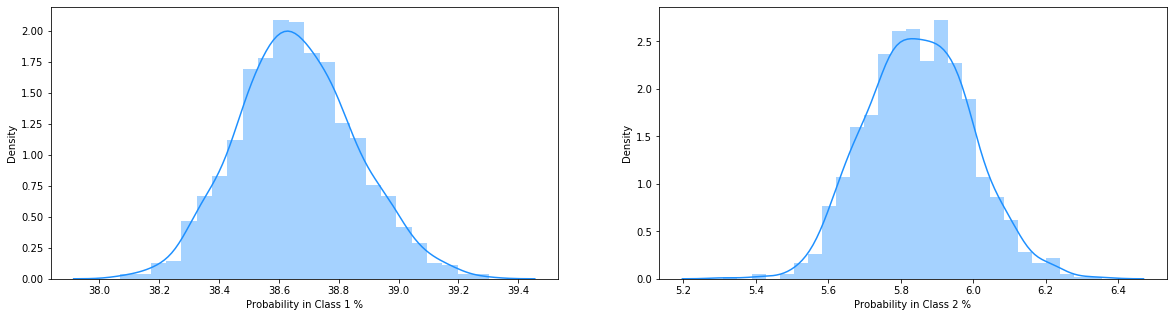

In [191]:
proba_predictions0 = p0.iloc[:,0].values
proba_predictions1 = p0.iloc[:,1].values
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(proba_predictions0.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in Class 1 %")
ax[0].set_ylabel("Density")
sns.distplot(proba_predictions1.flatten() * 100, color="DodgerBlue", ax=ax[1])
ax[1].set_xlabel("Probability in Class 2 %")
ax[1].set_ylabel("Density")

In [31]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [69]:
# Create CNN Model
class Fake_AlexNet(nn.Module):

    def __init__(self,nclasses=28):
        #self.nclasses=3 # This needs to be changed when using different number of classes for developing model
        super(Fake_AlexNet, self).__init__()
        self.ConvLayer1 = nn.Sequential(nn.Conv2d(in_channels=4, out_channels=32, kernel_size=12, stride=5, padding=0), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=3,stride=2)
                                       )
        self.ConvLayer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2,stride=2)
                                       )
        self.ConvLayer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=0), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=3,stride=2),                                        
                                       )
        self.dense = torch.nn.Sequential(
                                        nn.Linear(96*10*10, 2048),
                                        nn.ReLU(),
                                        torch.nn.Dropout(0.25),
                                        torch.nn.Linear(2048, 512),
                                        torch.nn.ReLU(),
                                        torch.nn.Dropout(0.25),
                                        torch.nn.Linear(512, nclasses)
                                        )
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        return x

In [77]:
model=Fake_AlexNet(nclasses=3)

criterion = FocalLoss()
optimizer = optim.Adam(model.parameters())

prob_threshold=0.5
process_model(model,train_loader,validation_loader,3,sigmoid=True)

Epoch: 0
tensor([[0.5111, 0.4947, 0.5049],
        [0.5097, 0.4944, 0.5051],
        [0.5092, 0.4954, 0.5043],
        [0.5103, 0.4963, 0.5044],
        [0.5099, 0.4966, 0.5047],
        [0.5100, 0.4940, 0.5029],
        [0.5092, 0.4962, 0.5056],
        [0.5116, 0.4948, 0.5045],
        [0.5109, 0.4941, 0.5048],
        [0.5095, 0.4940, 0.5044],
        [0.5096, 0.4967, 0.5056],
        [0.5103, 0.4937, 0.5058],
        [0.5103, 0.4958, 0.5042],
        [0.5087, 0.4951, 0.5033],
        [0.5098, 0.4945, 0.5045],
        [0.5101, 0.4954, 0.5043],
        [0.5100, 0.4950, 0.5057],
        [0.5108, 0.4940, 0.5029],
        [0.5090, 0.4961, 0.5025],
        [0.5105, 0.4957, 0.5039],
        [0.5099, 0.4967, 0.5048],
        [0.5103, 0.4954, 0.5042],
        [0.5103, 0.4941, 0.5040],
        [0.5100, 0.4951, 0.5046],
        [0.5088, 0.4953, 0.5058],
        [0.5093, 0.4961, 0.5047],
        [0.5114, 0.4952, 0.5037],
        [0.5099, 0.4931, 0.5044],
        [0.5097, 0.4948, 0.5035],
     

In [181]:
model_1=Fake_AlexNet(nclasses=3)

criterion = FocalLoss()
optimizer = optim.Adam(model_1.parameters())

prob_threshold=0.5
p = process_model(model_1,train_loader,validation_loader,1,sigmoid=True)

process...sigmoid = True
Epoch: 0
sigmoid actived.....
tensor([[0.4907, 0.4942, 0.5030],
        [0.4906, 0.4928, 0.5035],
        [0.4915, 0.4938, 0.5049],
        [0.4901, 0.4943, 0.5020],
        [0.4902, 0.4921, 0.5023],
        [0.4904, 0.4940, 0.5022],
        [0.4904, 0.4932, 0.5033],
        [0.4900, 0.4936, 0.5020],
        [0.4898, 0.4919, 0.5033],
        [0.4913, 0.4939, 0.5039],
        [0.4897, 0.4917, 0.5033],
        [0.4914, 0.4928, 0.5022],
        [0.4906, 0.4915, 0.5018],
        [0.4897, 0.4940, 0.5028],
        [0.4908, 0.4938, 0.5021],
        [0.4897, 0.4940, 0.5030],
        [0.4901, 0.4939, 0.5035],
        [0.4892, 0.4929, 0.5048],
        [0.4910, 0.4929, 0.5017],
        [0.4903, 0.4940, 0.5034],
        [0.4905, 0.4942, 0.5024],
        [0.4885, 0.4941, 0.5041],
        [0.4898, 0.4927, 0.5023],
        [0.4910, 0.4930, 0.5008],
        [0.4882, 0.4926, 0.5017],
        [0.4904, 0.4941, 0.5009],
        [0.4911, 0.4930, 0.5036],
        [0.4898, 0.4955, 0.

Text(0, 0.5, 'Density')

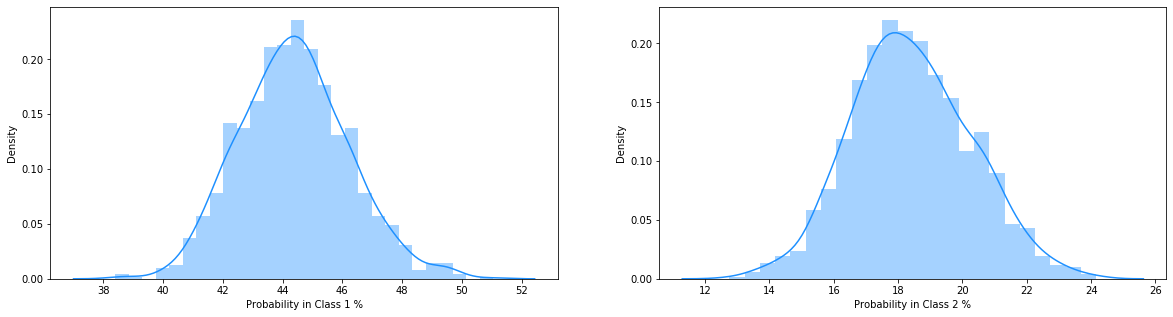

In [189]:
proba_predictions0 = p.iloc[:,0].values
proba_predictions1 = p.iloc[:,1].values
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(proba_predictions0.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in Class 1 %")
ax[0].set_ylabel("Density")
sns.distplot(proba_predictions1.flatten() * 100, color="DodgerBlue", ax=ax[1])
ax[1].set_xlabel("Probability in Class 2 %")
ax[1].set_ylabel("Density")

In [192]:
model_1=Fake_AlexNet(nclasses=3)

criterion = FocalLoss()
optimizer = optim.Adam(model_1.parameters())

prob_threshold=0.5
p = process_model(model_1,train_loader,validation_loader,3,sigmoid=True)

process...sigmoid = True
Epoch: 0
sigmoid actived.....
tensor([[0.5057, 0.5003, 0.4886],
        [0.5046, 0.5001, 0.4886],
        [0.5039, 0.4987, 0.4891],
        [0.5051, 0.5014, 0.4894],
        [0.5059, 0.5001, 0.4907],
        [0.5059, 0.4983, 0.4908],
        [0.5037, 0.5014, 0.4882],
        [0.5043, 0.4994, 0.4887],
        [0.5044, 0.4973, 0.4891],
        [0.5046, 0.5004, 0.4890],
        [0.5040, 0.4995, 0.4883],
        [0.5047, 0.4994, 0.4890],
        [0.5057, 0.4994, 0.4881],
        [0.5062, 0.5000, 0.4904],
        [0.5047, 0.5009, 0.4907],
        [0.5035, 0.4996, 0.4885],
        [0.5046, 0.5019, 0.4893],
        [0.5035, 0.4987, 0.4900],
        [0.5052, 0.5004, 0.4889],
        [0.5040, 0.5003, 0.4883],
        [0.5033, 0.5006, 0.4877],
        [0.5036, 0.4999, 0.4897],
        [0.5064, 0.4981, 0.4904],
        [0.5049, 0.4983, 0.4890],
        [0.5037, 0.5008, 0.4901],
        [0.5043, 0.4994, 0.4891],
        [0.5041, 0.5008, 0.4884],
        [0.5055, 0.5000, 0.

E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training loss is 0.3346766972287702 
training f1-score is 0.06757800432499227 
training macro f1-score is 0.04843980847031369 
training accuracy is 0.7985789311090515 
Epoch: 0
sigmoid actived.....
tensor([[0.4473, 0.2431, 0.3344],
        [0.4237, 0.2190, 0.3187],
        [0.4337, 0.2480, 0.3387],
        [0.4280, 0.2167, 0.3134],
        [0.4285, 0.2130, 0.3192],
        [0.4801, 0.2864, 0.3413],
        [0.4065, 0.2423, 0.3525],
        [0.4341, 0.2209, 0.3290],
        [0.4546, 0.2691, 0.3465],
        [0.4295, 0.2505, 0.3210],
        [0.4516, 0.2436, 0.3434],
        [0.4400, 0.2517, 0.3452],
        [0.4142, 0.2734, 0.3507],
        [0.4275, 0.2532, 0.3287],
        [0.4355, 0.2731, 0.3468],
        [0.4242, 0.2559, 0.3274],
        [0.4217, 0.2301, 0.3347],
        [0.4197, 0.2275, 0.3297],
        [0.4441, 0.2277, 0.3425],
        [0.4360, 0.2259, 0.3410],
        [0.4180, 0.2544, 0.3426],
        [0.4589, 0.2687, 0.3426],
        [0.4392, 0.2800, 0.3375],
        [0.4273, 0.2

Text(0, 0.5, 'Density')

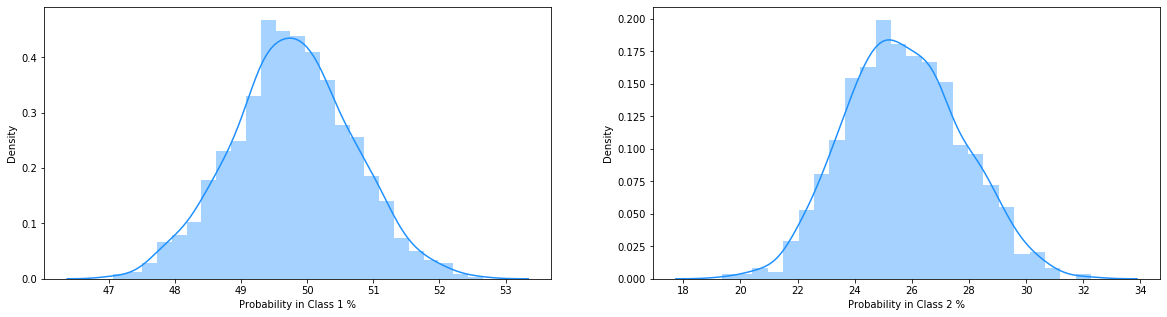

In [193]:
proba_predictions0 = p.iloc[:,0].values
proba_predictions1 = p.iloc[:,1].values
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(proba_predictions0.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in Class 1 %")
ax[0].set_ylabel("Density")
sns.distplot(proba_predictions1.flatten() * 100, color="DodgerBlue", ax=ax[1])
ax[1].set_xlabel("Probability in Class 2 %")
ax[1].set_ylabel("Density")

In [75]:
class FocalLoss2(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [109]:
model=MultiClassifier(nclasses=3)

criterion = FocalLoss2()
optimizer = optim.Adam(model.parameters())

prob_threshold=0.5
process_model(model,train_loader,validation_loader,3)

process...sigmoid = False
Epoch: 0
sigmoid not used.....
tensor([[0.5134, 0.5082, 0.4923],
        [0.5132, 0.5079, 0.4928],
        [0.5130, 0.5092, 0.4916],
        [0.5131, 0.5082, 0.4921],
        [0.5144, 0.5086, 0.4915],
        [0.5132, 0.5092, 0.4927],
        [0.5139, 0.5088, 0.4921],
        [0.5127, 0.5083, 0.4916],
        [0.5133, 0.5094, 0.4919],
        [0.5140, 0.5084, 0.4925],
        [0.5133, 0.5085, 0.4924],
        [0.5138, 0.5089, 0.4925],
        [0.5134, 0.5090, 0.4926],
        [0.5132, 0.5097, 0.4919],
        [0.5137, 0.5091, 0.4923],
        [0.5135, 0.5091, 0.4928],
        [0.5127, 0.5088, 0.4917],
        [0.5125, 0.5091, 0.4919],
        [0.5138, 0.5078, 0.4920],
        [0.5124, 0.5089, 0.4912],
        [0.5134, 0.5083, 0.4930],
        [0.5134, 0.5086, 0.4923],
        [0.5139, 0.5077, 0.4917],
        [0.5135, 0.5088, 0.4909],
        [0.5128, 0.5074, 0.4913],
        [0.5127, 0.5083, 0.4917],
        [0.5128, 0.5088, 0.4921],
        [0.5128, 0.5086, 

In [174]:
def pred_probablity(in_model, data_loader, sigmoid = False):
    in_model.eval()
    probablity = []
    for i, data in enumerate(data_loader):
        x = data['image']
        out_p = in_model(x)
        
        if sigmoid:
            out_p = torch.sigmoid(out_p.data)
        if i == 0:
            print(out_p)
        out_p = out_p.detach().numpy()
        for n in range(out_p.shape[0]):
            probablity.append(out_p[n])
    
    p = pd.DataFrame(probablity)
    return p

In [131]:
p = pred_probablity(model,validation_loader)
p.head()

,0,1,2
0,0.460425,0.280431,0.322261
1,0.460451,0.280531,0.322329
2,0.460466,0.280528,0.322312
3,0.460512,0.280788,0.322514
4,0.460466,0.280594,0.322378
...,...,...,...
1075,0.460477,0.280636,0.322407
1076,0.460425,0.280427,0.322259
1077,0.460392,0.280283,0.322153
1078,0.460482,0.280661,0.322427


In [ ]:
th = np.array([0.50,0.56,0.50,0.50,0.50,0.47,0.39,0.56,0.36,0.45,
               0.41,0.48,0.45,0.44,0.63,0.50,0.38,0.33,0.45,0.41,
               0.33,0.49,0.43,0.52,0.51,0.48,0.43,0.1])
